# Arithmetic Experiments

## Imports

In [1]:
from os.path import dirname, abspath
import sys, os
d = dirname(os.path.abspath(''))
sys.path.append(d)

from implicitdl import ImplicitModel, ImplicitModelLoRA, ImplicitFunctionInf, ImplicitFunctionTriu

import torch
from torch import nn
import torch.nn.functional as F
device = torch.device('cuda')
print('using ' + str(device))
torch.set_default_device(device)

import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# seed = 1234
# np.random.seed(seed)
# torch.manual_seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(seed)
    
%matplotlib inline

using cuda


/home/ubuntu/miniconda3/envs/sim/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Generation

In [2]:
DIM = 50
SAMPLES = 10000

randrange = lambda dim: sorted(np.random.choice(range(dim+1), size=2, replace=False))

funcs = {
    'add': lambda a, b: a+b,
    'sub': lambda a, b: a-b,
    'mul': lambda a, b: 0.5*a*b,
    'div': lambda a, b: a/b,
    'custom_1': lambda a, b: a + torch.sin(b),
    'custom_2': lambda a, b: a**3 - 3*b**2 + a**2*b,
}

# n, m = randrange(DIM)
# p, q = randrange(DIM)
n, m = 0, DIM//2
p, q = DIM//2, DIM

def make_data(lower, upper, func):
    X = torch.tensor(np.random.uniform(lower, upper, size=(SAMPLES, DIM)), device=device, dtype=torch.float)
    a = X[:, n:m].sum(axis=-1).unsqueeze(-1)
    b = X[:, p:q].sum(axis=-1).unsqueeze(-1)
    y = func(a, b)
    return X, y

# def make_data(lower, upper, func):
#     X = torch.tensor(np.random.uniform(lower, upper, size=(SAMPLES, DIM)), device=device, dtype=torch.float)
#     y = torch.sum(X, -1)
#     return X, y.unsqueeze(-1)

## Training Code

In [3]:
def train(model, X, y, epochs, lr):
    [nn.init.kaiming_uniform_(p, mode='fan_in', nonlinearity='relu') for p in model.parameters()]
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
    losses = []
    
    model.train()
    for _ in range(epochs):
        pred = model(X)
        loss = F.mse_loss(pred, y)
        l1_lambda = 0.01
        l1_norm = sum(torch.linalg.norm(p, 1) for p in model.parameters())
        loss = loss + l1_lambda * l1_norm
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        losses.append(loss.item())
        # it.set_postfix(lr=scheduler.get_last_lr()[0])
            
    return losses

## Model Generation
To override the default nonlinearity (ReLU), override the implicit function you wish to use, and replace the phi and dphi (gradient of nonlinearity) methods.

In [4]:
class CustomInf(ImplicitFunctionInf):
    """
    Change the default convergence parameters.
    """
    mitr = grad_mitr = 500
    tol = grad_tol = 1e-6

class ImplicitFunctionInfSiLU(CustomInf):
    """
    An implicit function that uses the SiLU nonlinearity.
    """
    # triu = False
    @staticmethod
    def phi(X):
        return X * torch.sigmoid(X)

    @staticmethod
    def dphi(X):
        grad = X.clone().detach()
        sigmoid = torch.sigmoid(grad)
        return sigmoid * (1 + grad * (1 - sigmoid))
    
class ImplicitFunctionTriuSiLU(ImplicitFunctionTriu):
    """
    An implicit function that uses the SiLU nonlinearity.
    """
    mitr = grad_mitr = 500
    tol = grad_tol = 1e-6
    # triu = True
    @staticmethod
    def phi(X):
        return X * torch.sigmoid(X)

    @staticmethod
    def dphi(X):
        grad = X.clone().detach()
        sigmoid = torch.sigmoid(grad)
        return sigmoid * (1 + grad * (1 - sigmoid))
    
def fuse_parameters(model):
    """Move model parameters to a contiguous tensor, and return that tensor."""
    n = sum(p.numel() for p in model.parameters())
    params = torch.zeros(n)
    i = 0
    for p in model.parameters():
        params_slice = params[i:i + p.numel()]
        params_slice.copy_(p.flatten())
        p.data = params_slice.view(p.shape)
        i += p.numel()
    return params

def compute_accuracy(y_pred, y_true):
    close = (torch.abs(y_pred - y_true)/torch.abs(y_true) < 1e-2).float()
    return close.mean()

In [5]:
input_size = DIM
lora_size = 2
hidden_size = 20
output_size = 1
more_state = 2
make_imp_relu = lambda: ImplicitModel(hidden_size, input_size, output_size, f=CustomInf, no_D=False)
make_imp_triu_l = lambda: ImplicitModel(hidden_size+more_state, input_size, output_size, f=ImplicitFunctionTriu, no_D=False)
make_imp_triu_s = lambda: ImplicitModel(hidden_size, input_size, output_size, f=ImplicitFunctionTriu, no_D=False)
make_imp_silu = lambda: ImplicitModel(hidden_size, input_size, output_size, f=ImplicitFunctionInfSiLU, no_D=False)
make_imp_triu_silu_l = lambda: ImplicitModel(hidden_size+more_state, input_size, output_size, f=ImplicitFunctionTriuSiLU, no_D=False)
make_imp_triu_silu_s = lambda: ImplicitModel(hidden_size, input_size, output_size, f=ImplicitFunctionTriuSiLU, no_D=False)
make_imp_lora = lambda: ImplicitModelLoRA(lora_size, hidden_size, input_size, output_size, f=CustomInf, no_D=False)

In [6]:
def make_mlp(act):
    return nn.Sequential(
        nn.Linear(DIM, hidden_size, bias=False),
        act(),
        nn.Linear(hidden_size, hidden_size, bias=False),
        act(),
        # nn.Linear(hidden_size, hidden_size, bias=False),
        # act(),
        nn.Linear(hidden_size, 1, bias=False),
    )

## Full Pipeline

In [7]:
EPOCHS = 500
LR = 0.08

In [8]:
# task = "add"
# task = "sub"
# task = "mul"
# task = 'div'
task = "custom_1"
# task = "custom_2"
X, y = make_data(-1, 1, funcs[task])

models = {
    'ImplicitLoRA': make_imp_lora().to(device),
    # 'ImplicitTriu_L': make_imp_triu_l().to(device),
    # 'ImplicitTriu_S': make_imp_triu_s().to(device),
    # 'ImplicitTriuSiLU_L': make_imp_triu_silu_l().to(device),
    # 'ImplicitTriuSiLU_S': make_imp_triu_silu_s().to(device),
    'Implicit': make_imp_relu().to(device),    
    # 'ImplicitSiLU': make_imp_silu().to(device),
    'MLP': make_mlp(nn.SiLU).to(device),
    # 'MLPSiLU': make_mlp(nn.SiLU).to(device)
}

print('Model Sizes:')
for name, model in models.items():
    if name == 'ImplicitTriuSiLU_L' or name == "ImplicitTriuSiLU_S":
    # if model.triu == True:
        print(name)
        size = model.A.detach().cpu().numpy().size
        non_learnable = int(size/2 - model.A.shape[0]/2)
        print(f'{name}: {sum(p.numel() for p in model.parameters()) - non_learnable} parameters')
    else:
        print(f'{name}: {sum(p.numel() for p in model.parameters())} parameters')
    # [nn.init.constant_(p, -0.01) for p in model.parameters()]


Model Sizes:
ImplicitLoRA: 2250 parameters
Implicit: 3690 parameters
MLP: 3640 parameters


In [9]:
num_exps = 10
factors = np.linspace(1, 10, num=10)
losses = {}

X_tests, y_tests = [], []
for factor in factors:
    X_test, y_test = make_data(-factor, factor, funcs[task])
    X_tests.append(X_test)
    y_tests.append(y_test)

losses = {name: [] for name in models}
extraps = {name: [[] for factor in factors] for name in models}
extraps_acc = {name: [[] for factor in factors] for name in models}
for name, model in models.items():
    print(name)
    for i in range(num_exps):
        losses[name].append(train(model, X, y, EPOCHS, LR))
        for k in range(len(factors)):
            with torch.no_grad():
                extraps[name][k].append(F.mse_loss(model(X_tests[k]), y_tests[k]).item())
                extraps_acc[name][k].append(compute_accuracy(model(X_tests[k]), y_tests[k]).item())

ImplicitLoRA


/home/ubuntu/khai.nx/implicit-deep-learning/implicitdl/implicit_function.py:19: ImplicitFunctionWarning: Picard iterations did not converge: err=1.9073e-06, status=max itrs reached
  warnings.warn(f"Picard iterations did not converge: err={err.item():.4e}, status={status}", ImplicitFunctionWarning)


Implicit
MLP


In [10]:
mean_losses = {name: [] for name in models}
std_losses = {name: [] for name in models}
mean_extraps = {name: [] for name in models}
std_extraps = {name: [] for name in models}
mean_extraps_acc = {name: [] for name in models}
std_extraps_acc = {name: [] for name in models}
for name, model in models.items():
    mean_losses[name] = np.mean(losses[name], 0)
    std_losses[name] = np.std(losses[name], 0)
    mean_extraps[name] = np.mean(extraps[name], 1)
    std_extraps[name] = np.std(extraps[name], 1)
    mean_extraps_acc[name] = np.mean(extraps_acc[name], 1)
    std_extraps_acc[name] = np.std(extraps_acc[name], 1)
    print(name)
    print(" train(lasso):", mean_losses[name][-1])
    print(" test(mse):", mean_extraps[name][0])
    print(" std(mse):", std_extraps[name][0])
    print(" acc:", mean_extraps_acc[name][0])
    params = fuse_parameters(model)
    print(" nonzeros:", torch.count_nonzero(params).item())
    print("\n")
my_task = (task, mean_losses, std_losses, mean_extraps)

ImplicitLoRA
 train(lasso): 0.4497432500123978
 test(mse): 0.6482825696468353
 std(mse): 0.019798372645725256
 acc: 0.016560000088065862
 nonzeros: 2250


Implicit
 train(lasso): 1.1779630780220032
 test(mse): 0.41182760894298553
 std(mse): 0.20119669016173408
 acc: 0.03774999873712659
 nonzeros: 3690


MLP
 train(lasso): 0.16813880056142808
 test(mse): 0.06090834327042103
 std(mse): 0.0207859412036183
 acc: 0.10979999825358391
 nonzeros: 3640




## Plot Results

In [11]:
styles = ['-', '-.', '--', ':', '-', '-.', '--', ':']

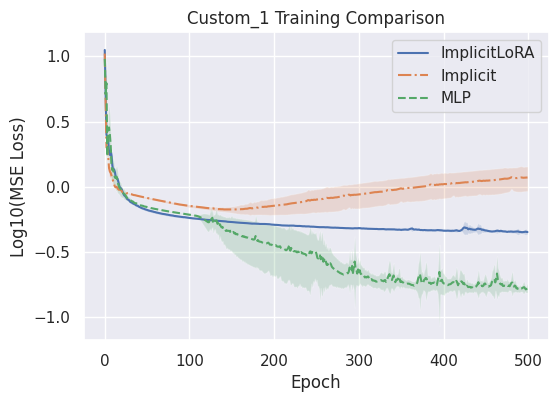

In [12]:
my_task = (task, mean_losses, std_losses, mean_extraps, std_extraps)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plt.rcParams['axes.grid'] = True
for ax, (name, mean_loss, std_loss, _, _) in zip([axes], [my_task]):
    
    for style, (model_name, model_loss), (_, model_loss_std)  in zip(styles, mean_loss.items(), std_loss.items()):
        ax.plot(range(len(model_loss)), np.log10(model_loss), label=model_name, ls=style)
        ax.fill_between(range(len(model_loss)), np.log10(model_loss - model_loss_std), np.log10(model_loss + model_loss_std), alpha=0.2)
        # ax.plot(range(len(model_loss)), (model_loss), label=model_name, ls=style)
        # ax.fill_between(range(len(model_loss)), (model_loss - model_loss_std),(model_loss + model_loss_std), alpha=0.2)    
    # ax.set_ylim(-5, 2)
    ax.set_title(f'{name.title()} Training Comparison')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Log10(MSE Loss)')
    ax.legend()
    
plt.show()

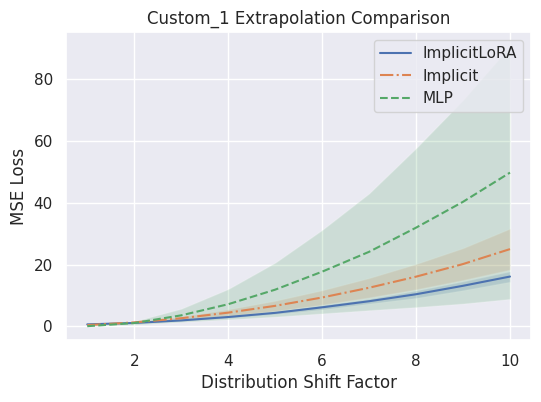

In [13]:
my_task = (task, mean_losses, std_losses, mean_extraps, std_extraps)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
for ax, (name, _, _, mean_extrap, std_extrap) in zip([axes], [my_task]):
    
    for style, (model_name, model_extrap), (_, model_extrap_std) in zip(styles, mean_extrap.items(), std_extrap.items()):
        # ax.plot(factors, np.log10(model_extrap), label=model_name, ls=style)
        # ax.fill_between(factors, np.log10(model_extrap - model_extrap_std), np.log10(model_extrap + model_extrap_std), alpha=0.2)
        ax.plot(factors, (model_extrap), label=model_name, ls=style)
        ax.fill_between(factors, (model_extrap - model_extrap_std), (model_extrap + model_extrap_std), alpha=0.2)
    
    # ax.set_ylim(-5, 10)
    ax.set_title(f'{name.title()} Extrapolation Comparison')
    ax.set_xlabel('Distribution Shift Factor')
    # ax.set_ylabel('Log10(MSE Loss)')
    ax.set_ylabel('MSE Loss')
    ax.legend()
    
plt.show()

In [14]:
import matplotlib.pyplot as plt
import scipy.sparse as sp

# model_name = 'Implicit'
# model_name = 'ImplicitTriuSiLU_L'
# model_name = 'ImplicitTriuSiLU_S'
model_name = 'ImplicitLoRA'
vis_model = models[model_name].to('cpu')
if model_name == "ImplicitLoRA":
    matrix = np.abs((vis_model.L @ vis_model.R.transpose(-1,-2)).detach().numpy())
else:
    matrix = np.abs(vis_model.A.detach().numpy())
# print(matrix)
print("rank:", np.linalg.matrix_rank(matrix))
norm_inf_A = np.linalg.norm(matrix, ord=float('inf')) 
print("norm:", norm_inf_A)

# plt.rcParams['axes.grid'] = False
# plt.figure(figsize=(6, 4))
# non_zero_weights = np.isclose(matrix, 0, 1e-5) == False
# im = plt.imshow(non_zero_weights, cmap='Greys', aspect='equal')
# plt.title(f'{model_name}: n_params = {matrix.size}, n_nonzeros = {np.count_nonzero(non_zero_weights)}\n')
# plt.xlabel('Input Neurons')
# plt.ylabel('Output Neurons')

# cbar = plt.colorbar(im)
# cbar.set_label('Weight Magnitude')

# plt.tight_layout()
# plt.show()

rank: 26
norm: 0.074111745


how to evaluate sparsity:
- absolute number of nonzeros
- percentage of nonzeros

robustness
- enable some random lower triangular elements, increase 10% number of parameters, add L1 norm (encourage sparsity, reduce 10% number of nonzeros) and hope for better performance and robustness

In [15]:
A1_np = np.array([[1],[-1.2],[2]])/2
A2_np = np.array([[3, 2.2, -4.3]])
A_np = A1_np @ A2_np
# A_np = np.array([[3, 1, -2.1], [4, -5, 6.3], [-7, 8.1, 9]])/3
# project A on |A|_inf=v
v = 0.95
print(A_np)
x = np.abs(A_np).sum(axis=-1)
print(x)
print("rank of A", np.linalg.matrix_rank(A_np))
for idx in np.where(x > v)[0]:
    # read the vector
    a_orig = A_np[idx, :]
    # print(a_orig)
    a_sign = np.sign(a_orig)
    # print(a_sign)
    a_abs = np.abs(a_orig)
    # print(a_abs)
    a = np.sort(a_abs)
    # print(a)

    s = np.sum(a) - v
    l = float(len(a))
    for i in range(len(a)):
        if s / l > a[i]:
            s -= a[i]
            l -= 1
        else:
            break
    # print(s, l)
    alpha = s / l
    a = a_sign * np.maximum(a_abs - alpha, 0)
    # verify
    # print(a)
    assert np.isclose(np.abs(a).sum(), v)
    # write back
    A_np[idx, :] = a
print(A_np)
print(np.abs(A_np).sum(axis=-1))
print("rank of A'", np.linalg.matrix_rank(A_np))

print("=======")
A_test = torch.rand((3,3))*5
print(A_test)
norm_inf_A = torch.linalg.matrix_norm(A_test, ord=float('inf')) 
print(norm_inf_A)
A_test = 0.95*A_test/norm_inf_A
norm_inf_A = torch.linalg.matrix_norm(A_test, ord=float('inf')) 
print(A_test)
print(norm_inf_A)

[[ 1.5   1.1  -2.15]
 [-1.8  -1.32  2.58]
 [ 3.    2.2  -4.3 ]]
[4.75 5.7  9.5 ]
rank of A 1
[[ 0.15   0.    -0.8  ]
 [-0.085 -0.     0.865]
 [ 0.     0.    -0.95 ]]
[0.95 0.95 0.95]
rank of A' 2
tensor([[1.8051, 3.8770, 2.4418],
        [2.9088, 3.1474, 1.4818],
        [2.4052, 4.4497, 3.1942]], device='cuda:0')
tensor(10.0491, device='cuda:0')
tensor([[0.1706, 0.3665, 0.2308],
        [0.2750, 0.2975, 0.1401],
        [0.2274, 0.4207, 0.3020]], device='cuda:0')
tensor(0.9500, device='cuda:0')


In [16]:
n = 4
r = 1
A1_np = np.random.rand(10,5)
A2_np = np.random.rand(5,10)
print(A1_np)
norm_A1 = np.linalg.norm(A1_np, ord=float('inf'))
print(norm_A1)
norm_A2 = np.linalg.norm(A2_np, ord=float('inf'))
print(norm_A2)
norm_A = np.linalg.norm(A1_np @ A2_np, ord=float('inf'))
print(norm_A)
print(norm_A - norm_A1 * norm_A2)

[[9.74900735e-02 8.95116440e-01 4.07203140e-01 3.68086722e-01
  7.30055801e-01]
 [8.27144461e-01 8.43706298e-01 7.38716330e-01 2.30106852e-01
  8.52897221e-04]
 [1.21389902e-01 6.05928815e-01 3.24229916e-01 6.61686790e-01
  2.28904690e-01]
 [5.46891855e-01 2.43230140e-01 9.11342574e-01 6.66099279e-01
  1.36629056e-01]
 [3.79540258e-01 8.51622699e-02 3.23202857e-01 7.70277627e-01
  4.28113079e-01]
 [7.51954902e-01 4.32666516e-01 5.13453568e-01 9.78995661e-01
  8.87085615e-01]
 [4.05382162e-02 9.23332110e-01 1.31783132e-01 7.20064628e-02
  3.12039390e-01]
 [9.66804548e-03 3.95299138e-01 3.04738714e-01 8.02092309e-02
  9.60072482e-01]
 [2.52169875e-01 6.93075754e-01 1.02976337e-01 9.19348657e-02
  7.96803976e-04]
 [1.30095236e-01 2.07323885e-01 5.28102085e-01 2.08934571e-01
  8.17150437e-02]]
3.5641562621925735
5.616464758541431
18.247764302400512
-1.770193738138829


In [17]:
np.linalg.norm(A2_np.transpose(), ord=float('inf'))

3.7270875450063867